In [1]:
import torch
import torch.linalg as tla
import numpy as np
import matplotlib.pyplot as plt
import numml.sparse as sp

In [2]:
# Create our favorite poisson operator

N = 9
A = sp.eye(N)*2. - sp.eye(N, k=1) - sp.eye(N, k=-1)
b = torch.zeros(N)
b[N//2] = 1.
print(A.to_dense())

tensor([[ 2., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [-1.,  2., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  2., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  2., -1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  2., -1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., -1.,  2., -1.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., -1.,  2., -1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  2., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  2.]])


In [3]:
# Create a tentative aggregation operator

Agg = torch.Tensor([
    [1, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 1, 1]
]).T
Agg = sp.SparseCSRTensor(Agg)

In [11]:
# Optimize a smoother for the agg op

S = A.copy()
S_orig = S.copy()
S.requires_grad = True

In [12]:
# multigrid cycle and jacobi smoother

def jacobi(A, x, b, omega=0.6):
    Dinv = sp.diag(1./A.diagonal())
    return omega * (Dinv @ b) + (sp.eye(A.shape[0]) - omega * (Dinv@A)) @ x

def mgrid(P, A, x, b):
    x = jacobi(A, x, b)
    r_H = P.T @ (b - A @ x)
    A_H = P.T @ A @ P
    x = x + P @ sp.spsolve(A_H, r_H)
    x = jacobi(A, x, b)
    return x

def mgrid_solver(P, A, x, b, iterations=100):
    res_history = torch.zeros(iterations)
    res_history[0] = tla.norm(b-A@x)/tla.norm(b)
    
    for i in range(1, iterations):
        x = mgrid(P, A, x, b)
        res_history[i] = tla.norm(b-A@x)/tla.norm(b)
    return res_history

In [13]:
# Optimize over the entries of S to create an optimal smoother
# we'll use a few multigrid iterations for the loss

optimizer = torch.optim.Adam([S.data], lr=0.1)
batch = 20
mgrid_it = 3
lh = []

x_test = torch.randn(batch, N)
x_test /= tla.norm(x_test, dim=0)

for i in range(5_000):
    optimizer.zero_grad()
    
    # Compute smoother
    P = S @ Agg
    
    loss = 0.
    for j in range(batch):
        # Random initial guess and a few multigrid iterations
        x0 = x_test[j]
        x1 = x0
        for k in range(mgrid_it):
            x1 = mgrid(P, A, x1, b)

        # compute loss as rel residual of x / rel residual of x0
        r0 = tla.norm(b-A@x0) / tla.norm(b)
        r1 = tla.norm(b-A@x1) / tla.norm(b)

        loss += (r1 / r0) / batch
    loss.backward()
    
    optimizer.step()
    
    lh.append(loss.item())
    if i % 10 == 0:
        print(i, 'loss:', loss.item())
    if loss.item() < 0.007:
        print(i, 'loss:', loss.item())
        break

0 loss: 0.2269980013370514
10 loss: 0.05010077357292175
20 loss: 0.015591942705214024
30 loss: 0.013691790401935577
40 loss: 0.011522858403623104
50 loss: 0.010177584365010262
60 loss: 0.009155437350273132
70 loss: 0.008512374013662338
80 loss: 0.007949753664433956
90 loss: 0.007466273847967386
100 loss: 0.00705501064658165
102 loss: 0.006984091363847256


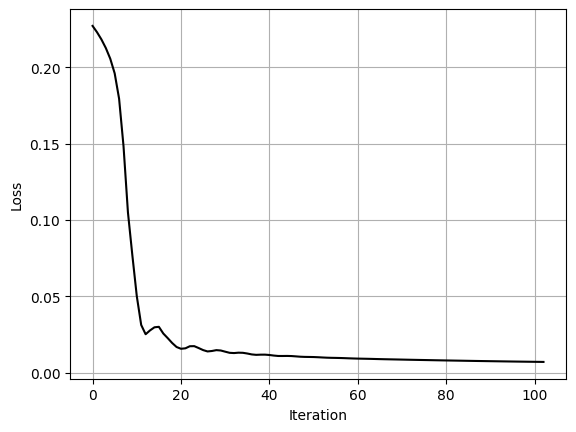

In [14]:
Lh = np.array(lh)

plt.figure()
plt.plot(Lh, 'k')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()

In [15]:
# Run our candidate smoothers on a random guess

x0 = torch.randn(N); x0 /= tla.norm(x0)

orig_res = None
opt_res = None

with torch.no_grad():
    orig_res = mgrid_solver((sp.eye(N) - 0.4*A) @ Agg, A, x0, b)
    opt_res = mgrid_solver(S @ Agg, A, x0, b)

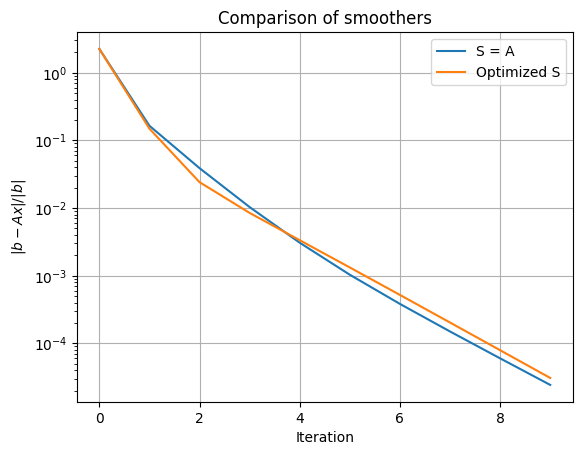

In [16]:
plt.title('Comparison of smoothers')
plt.semilogy(orig_res[:10], label='S = A')
plt.semilogy(opt_res[:10], label='Optimized S')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('$\|b - Ax\| / \|b\|$')
plt.legend()